# Import  lib

In [162]:
import tensorflow as tf
import numpy as np
from google.colab import drive
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from textwrap import wrap
from google.colab import drive
from tensorflow.keras.utils import plot_model

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# Connect google drive

In [163]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# PREPARE DATA of caption ( change to your path )

In [164]:
file_path = "/content/drive/MyDrive/projectMLDL/text/data_for_ml_27_image.csv"
df = pd.read_csv(file_path)

In [165]:
np.unique(df["image"])

array(['190246_0.jpg', '190248_0.jpg', '190249.jpg', '192437_0.jpg',
       '192441_0.jpg', '192442_0.jpg', '192444_0.jpg', 'IMG_0225.JPG',
       'IMG_0226.JPG', 'IMG_0229.JPG', 'IMG_0230.JPG', 'IMG_0231.JPG',
       'IMG_0232.JPG', 'IMG_0233.JPG', 'IMG_0235.JPG', 'IMG_0257.JPG',
       'IMG_0258.jpg', 'IMG_0259.jpg', 'IMG_0386.JPG', 'IMG_0389.jpg',
       'IMG_0390.jpg', 'IMG_0391.jpg', 'IMG_20231007_141008.jpg',
       'IMG_25660913_083131.jpg', 'IMG_25660913_132501.jpg',
       'IMG_25660920_150148.jpg', 'line_1.jpg'], dtype=object)

In [166]:
df['image'].nunique()

27

In [167]:
images = df['image']
captions = df['caption']

In [168]:
captions[30:]

30           A man is wearing ? the earphone
31             A man is sitting on the chair
32              A man is cutting ? the model
33              A man is sitting in the room
34     The student is working near the table
                       ...                  
130                  Two man are tired ? ? ?
131                Two man are resting ? ? ?
132        A student are sleep  on the chair
133    The students are resting on the chair
134        A student is sitting on the chair
Name: caption, Length: 105, dtype: object

In [169]:
all_captions = []

for caption in captions:
  caption_splited = ["" if word == "?" else word for word in caption.split()]
  all_captions.append(caption_splited)

In [170]:
len(all_captions)

135

In [171]:
# Assuming you have a DataFrame called unique_categories
categories = {
    'first_article': [],
    'subject': [],
    'verb_to_be': [],
    'verb': [],
    'preposition': [],
    'second_article': [],
    'objective': []
}

for caption in all_captions:
    for i, category in enumerate(categories.keys()):
        categories[category].append(caption[i].lower())

In [172]:
unique_categories = {category: list(set(values)) for category, values in categories.items()}

lb = LabelEncoder()

# Create a label encoder for each column
label_encoder_first_article = LabelEncoder()
label_encoder_subject = LabelEncoder()
label_encoder_verb_to_be = LabelEncoder()
label_encoder_verb = LabelEncoder()
label_encoder_preposition = LabelEncoder()
label_encoder_second_article = LabelEncoder()
label_encoder_objective = LabelEncoder()

# Fit and transform each column
unique_categories['first_article'] = label_encoder_first_article.fit_transform(unique_categories['first_article'])
unique_categories['subject'] = label_encoder_subject.fit_transform(unique_categories['subject'])
unique_categories['verb_to_be'] = label_encoder_verb_to_be.fit_transform(unique_categories['verb_to_be'])
unique_categories['verb'] = label_encoder_verb.fit_transform(unique_categories['verb'])
unique_categories['preposition'] = label_encoder_preposition.fit_transform(unique_categories['preposition'])
unique_categories['second_article'] = label_encoder_second_article.fit_transform(unique_categories['second_article'])
unique_categories['objective'] = label_encoder_objective.fit_transform(unique_categories['objective'])

# Your existing code for one-hot encoding
article_ = tf.keras.utils.to_categorical(unique_categories['first_article'], num_classes=len(label_encoder_first_article.classes_))
subject_ = tf.keras.utils.to_categorical(unique_categories['subject'], num_classes=len(label_encoder_subject.classes_))
verb_to_be_ = tf.keras.utils.to_categorical(unique_categories['verb_to_be'], num_classes=len(label_encoder_verb_to_be.classes_))
verb_ = tf.keras.utils.to_categorical(unique_categories['verb'], num_classes=len(label_encoder_verb.classes_))
preposition_ = tf.keras.utils.to_categorical(unique_categories['preposition'], num_classes=len(label_encoder_preposition.classes_))
second_article_ = tf.keras.utils.to_categorical(unique_categories['second_article'], num_classes=len(label_encoder_second_article.classes_))
objective_ = tf.keras.utils.to_categorical(unique_categories['objective'], num_classes=len(label_encoder_objective.classes_))

# Reverse one-hot encoding for each category
reverse_first_article = sorted(label_encoder_first_article.inverse_transform(np.argmax(article_, axis=1)))
reverse_subject = sorted(label_encoder_subject.inverse_transform(np.argmax(subject_, axis=1)))
reverse_verb_to_be = sorted(label_encoder_verb_to_be.inverse_transform(np.argmax(verb_to_be_, axis=1)))
reverse_verb = sorted(label_encoder_verb.inverse_transform(np.argmax(verb_, axis=1)))
reverse_preposition = sorted(label_encoder_preposition.inverse_transform(np.argmax(preposition_, axis=1)))
reverse_second_article = sorted(label_encoder_second_article.inverse_transform(np.argmax(second_article_, axis=1)))
reverse_objective = sorted(label_encoder_objective.inverse_transform(np.argmax(objective_, axis=1)))

# Print the results
print("Reverse First Article:", reverse_first_article)
print("Reverse Subject:", reverse_subject)
print("Reverse Verb to Be:", reverse_verb_to_be)
print("Reverse Verb:", reverse_verb)
print("Reverse Preposition:", reverse_preposition)
print("Reverse Second Article:", reverse_second_article)
print("Reverse Objective:", reverse_objective)

Reverse First Article: ['', 'a', 'four', 'many', 'one', 'the', 'three', 'threee', 'two']
Reverse Subject: ['bag', 'bottle', 'char', 'computer', 'laptop', 'man', 'men', 'people', 'student', 'students', 'table', 'team', 'wire']
Reverse Verb to Be: ['', 'are', 'do', 'has', 'is', 'thumbs', 'thump']
Reverse Verb: ['', 'are', 'been', 'collecting', 'coming', 'cutting', 'discussing', 'doing', 'eating', 'enjoy', 'full', 'funning', 'happy', 'having', 'holding', 'hungry', 'is', 'place', 'playing', 'pointing', 'programming', 'project', 'reading', 'relax', 'resting', 'rise', 'serious', 'sitting', 'sleep', 'smile', 'standing', 'studing', 'studying', 'talking', 'tired', 'up', 'use', 'used', 'waitting', 'walking', 'wearing', 'working']
Reverse Preposition: ['', 'about', 'after', 'around', 'at', 'behind', 'by', 'for', 'front', 'in', 'infrontof', 'near', 'on', 'sitting', 'to', 'when', 'with']
Reverse Second Article: ['', 'a', 'black', 'blue', 'by', 'his', 'laboratory', 'the']
Reverse Objective: ['', 'ai

In [173]:
print('first article = ',len(unique_categories['first_article']))
print('subject = ',len(unique_categories['subject']))
print('verb to be = ',len(unique_categories['verb_to_be']))
print('verb = ',len(unique_categories['verb']))
print('preposition = ',len(unique_categories['preposition']))
print('second article = ',len(unique_categories['second_article']))
print('objective = ',len(unique_categories['objective']))

first article =  9
subject =  13
verb to be =  7
verb =  42
preposition =  17
second article =  8
objective =  37


USE LABEL ENCODER FOR ENCODE UNIQUE_CATEGORIES DATA

In [174]:
lb = LabelEncoder()

for name in categories.keys():
  unique_categories[name] = lb.fit_transform(unique_categories[name])

In [175]:
label_encoder = LabelEncoder()
categories["first_article"] = label_encoder.fit_transform(categories["first_article"])
categories['subject'] = label_encoder.fit_transform(categories['subject'])
categories['verb_to_be'] = label_encoder.fit_transform(categories['verb_to_be'])
categories['verb'] = label_encoder.fit_transform(categories['verb'])
categories['preposition'] = label_encoder.fit_transform(categories['preposition'])
categories['second_article'] = label_encoder.fit_transform(categories['second_article'])
categories['objective'] = label_encoder.fit_transform(categories['objective'])

article = tf.keras.utils.to_categorical(categories["first_article"], len(unique_categories['first_article']))
subject = tf.keras.utils.to_categorical(categories['subject'], len(unique_categories['subject']))
verb_to_be = tf.keras.utils.to_categorical(categories['verb_to_be'], len(unique_categories['verb_to_be']))
verb = tf.keras.utils.to_categorical(categories['verb'], len(unique_categories['verb']))
preposition = tf.keras.utils.to_categorical(categories['preposition'], len(unique_categories['preposition']))
second_article = tf.keras.utils.to_categorical(categories['second_article'], len(unique_categories['second_article']))
objective = tf.keras.utils.to_categorical(categories['objective'], len(unique_categories['objective']))

In [176]:
def create_data():
  y = []
  for n in range(len(categories["first_article"])):
    y.append([categories["first_article"][n],
              categories["subject"][n],
              categories["verb_to_be"][n],
              categories["verb"][n],
              categories["preposition"][n],
              categories["second_article"][n],
              categories["objective"][n]])
  return np.array(y)

y_train = create_data()

In [177]:
y_train.shape

(135, 7)

In [178]:
y_train

array([[ 5,  8,  4, 27, 12,  7,  4],
       [ 1,  5,  4, 18,  0,  7,  8],
       [ 1,  8,  4, 20, 12,  7,  8],
       [ 1,  8,  4, 41, 12,  0,  8],
       [ 1,  5,  4, 27, 11,  7, 24],
       [ 8,  6,  1, 30, 11,  7, 32],
       [ 8,  6,  1, 41, 11,  7, 32],
       [ 8,  6,  1, 30,  9,  7, 18],
       [ 8,  8,  1, 30, 10,  7, 32],
       [ 0,  9,  1, 41,  9,  7, 28],
       [ 1,  5,  4, 39,  9,  7, 28],
       [ 1,  5,  4, 39, 12,  7, 10],
       [ 1,  5,  4,  4, 14,  7, 28],
       [ 5,  7,  1, 27, 12,  7,  4],
       [ 5,  7,  1, 22,  0,  7,  3],
       [ 1,  5,  4, 27, 12,  7,  4],
       [ 1,  5,  4, 27,  5,  7, 32],
       [ 5, 12,  1,  0, 12,  7, 32],
       [ 5, 10,  4,  0, 10,  7, 21],
       [ 1,  5,  4, 27,  9,  7, 28],
       [ 1,  5,  4, 27, 12,  7,  4],
       [ 1,  5,  4, 27,  9,  7, 28],
       [ 1,  5,  4, 25,  0,  7, 15],
       [ 1,  5,  4, 19,  4,  0,  1],
       [ 5,  5,  4, 27, 11,  7, 32],
       [ 1,  5,  4, 41, 12,  7,  8],
       [ 1,  5,  4, 27, 10,  7,  8],
 

# TRAIN IMAGE DATA ( change to your path )

In [179]:
image_path = "/content/drive/MyDrive/projectMLDL/img"

In [180]:
model = DenseNet201()
# model = DenseNet201(weights='imagenet', include_top=False)
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = []
for image in tqdm(df['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features.append(list(feature))

100%|██████████| 27/27 [00:15<00:00,  1.70it/s]


In [181]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.densenet import DenseNet201, preprocess_input
from keras.models import Model
import os
import numpy as np
from tqdm import tqdm

model = DenseNet201(weights='imagenet', include_top=True)

# Create a feature extraction model
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
batch_size = 32  # You can adjust this based on your available memory

features = []

for image in tqdm(df['image'].unique().tolist()):
    img_path = os.path.join(image_path, image)
    img = load_img(img_path, target_size=(img_size, img_size))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)  # Use DenseNet201's preprocessing function
    features.append(fe.predict(img, verbose=0))

# Convert the features list to a NumPy array
features = np.vstack(features)

100%|██████████| 27/27 [00:15<00:00,  1.72it/s]


In [182]:
features = np.array(features)
features.shape

(27, 1920)

reshape for model training

In [183]:
features = np.array(features).reshape(features.shape[0], 1920,)

STORE IMAGE VALUE AFTER TRAIN WITH DENSENET TO X VARIABLE

In [184]:
X = []

for idx, image in enumerate(features):
  for i in range(5):
    X.append(image)

In [185]:
X = np.array(X)
X.shape

(135, 1920)

# PREPARE DATA FOR TRAINING

In [193]:
input_data = {
    "image_feature": X,
    "captions": y_train
}

output_data = {
    "article": article,
    "subject": subject,
    "verb_to_be": verb_to_be,
    "verb": verb,
    "prep": preposition,
    "article2": second_article,
    "objective": objective
}

In [194]:
len(article_)

9

# MODEL

LSTM MODEL

In [195]:
import tensorflow as tf

image_features = tf.keras.layers.Input(shape=(1920,), name="image_feature")

captions = tf.keras.layers.Input(shape=(7,), name="captions")

caption_embedding = tf.keras.layers.Embedding(input_dim=123, output_dim=256)(captions)

captions_lstm = tf.keras.layers.LSTM(256)(caption_embedding)

captions_lstm = tf.keras.layers.Dense(256)(captions_lstm)

merged = tf.keras.layers.concatenate([image_features, captions_lstm], axis=-1)

x = tf.keras.layers.Dense(128, activation="relu")(merged)
# x = tf.keras.layers.Dense(64, activation="relu")(merged)
x = tf.keras.layers.Dropout(0.3)(x)

article_layer = tf.keras.layers.Dense(13, activation="softmax", name="article")(x)
subject_layer = tf.keras.layers.Dense(18, activation="softmax", name="subject")(x)
verb_to_be_layer = tf.keras.layers.Dense(7, activation="softmax", name="verb_to_be")(x)
verb_layer = tf.keras.layers.Dense(43, activation="softmax", name="verb")(x)
preposition_layer = tf.keras.layers.Dense(17, activation="softmax", name="prep")(x)
second_article_layer = tf.keras.layers.Dense(10, activation="softmax", name="article2")(x)
objective_layer = tf.keras.layers.Dense(45, activation="softmax", name="objective")(x)


caption_model = tf.keras.models.Model(inputs=[image_features, captions], outputs=[article_layer, subject_layer, verb_to_be_layer, verb_layer, preposition_layer, second_article_layer, objective_layer])

CNN MODE NOW THIS MODEL IS HIGH PERFORMANCE

In [196]:
import tensorflow as tf

image_features = tf.keras.layers.Input(shape=(1920,), name="image_feature")
captions = tf.keras.layers.Input(shape=(7,), name="captions")

captions_reshaped = tf.keras.layers.Reshape((7, 1))(captions)

caption_conv1d_1 = tf.keras.layers.Conv1D(256, kernel_size=3, activation='relu')(captions_reshaped)
caption_maxpool_1 = tf.keras.layers.GlobalMaxPooling1D()(caption_conv1d_1)

merged = tf.keras.layers.concatenate([image_features, caption_maxpool_1], axis=-1)

x = tf.keras.layers.Dense(128, activation="relu")(merged)
x = tf.keras.layers.Dropout(0.3)(x)

caption_conv1d_2 = tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu')(captions_reshaped)
caption_maxpool_2 = tf.keras.layers.GlobalMaxPooling1D()(caption_conv1d_2)

merged_2 = tf.keras.layers.concatenate([image_features, caption_maxpool_2], axis=-1)

x_2 = tf.keras.layers.Dense(64, activation="relu")(merged_2)
x_2 = tf.keras.layers.Dropout(0.2)(x_2)

x_3 = tf.keras.layers.Dense(32, activation="relu")(x_2)
x_3 = tf.keras.layers.Dropout(0.2)(x_3)

article_layer = tf.keras.layers.Dense(len(unique_categories['first_article']), activation="softmax", name="article")(x_3)
subject_layer = tf.keras.layers.Dense(len(unique_categories['subject']), activation="softmax", name="subject")(x_3)
verb_to_be_layer = tf.keras.layers.Dense(len(unique_categories['verb_to_be']), activation="softmax", name="verb_to_be")(x_3)
verb_layer = tf.keras.layers.Dense(len(unique_categories['verb']), activation="softmax", name="verb")(x_3)
preposition_layer = tf.keras.layers.Dense(len(unique_categories['preposition']), activation="softmax", name="prep")(x_3)
second_article_layer = tf.keras.layers.Dense(len(unique_categories['second_article']), activation="softmax", name="article2")(x_3)
objective_layer = tf.keras.layers.Dense(len(unique_categories['objective']), activation="softmax", name="objective")(x_3)

caption_model = tf.keras.models.Model(inputs=[image_features, captions], outputs=[article_layer, subject_layer, verb_to_be_layer, verb_layer, preposition_layer, second_article_layer, objective_layer])

In [197]:
import tensorflow as tf

image_features = tf.keras.layers.Input(shape=(1920,), name="image_feature")
captions = tf.keras.layers.Input(shape=(7,), name="captions")

captions_reshaped = tf.keras.layers.Reshape((7, 1))(captions)

caption_conv1d_1 = tf.keras.layers.Conv1D(256, kernel_size=3, activation='relu')(captions_reshaped)
caption_maxpool_2 = tf.keras.layers.GlobalMaxPooling1D()(caption_conv1d_1)

merged = tf.keras.layers.concatenate([image_features, caption_maxpool_2], axis=-1)

x_2 = tf.keras.layers.Dense(128, activation="sigmoid")(merged)
x_2 = tf.keras.layers.Dropout(0.2)(x_2)

x_3 = tf.keras.layers.Dense(64, activation="sigmoid")(x_2)
x_3 = tf.keras.layers.Dropout(0.2)(x_3)

article_layer = tf.keras.layers.Dense(len(unique_categories['first_article']), activation="softmax", name="article")(x_3)
subject_layer = tf.keras.layers.Dense(len(unique_categories['subject']), activation="softmax", name="subject")(x_3)
verb_to_be_layer = tf.keras.layers.Dense(len(unique_categories['verb_to_be']), activation="softmax", name="verb_to_be")(x_3)
verb_layer = tf.keras.layers.Dense(len(unique_categories['verb']), activation="softmax", name="verb")(x_3)
preposition_layer = tf.keras.layers.Dense(len(unique_categories['preposition']), activation="softmax", name="prep")(x_3)
second_article_layer = tf.keras.layers.Dense(len(unique_categories['second_article']), activation="softmax", name="article2")(x_3)
objective_layer = tf.keras.layers.Dense(len(unique_categories['objective']), activation="softmax", name="objective")(x_3)

caption_model = tf.keras.models.Model(inputs=[image_features, captions], outputs=[article_layer, subject_layer, verb_to_be_layer, verb_layer, preposition_layer, second_article_layer, objective_layer])

DISPLAY MODEL ARCHITECTURE

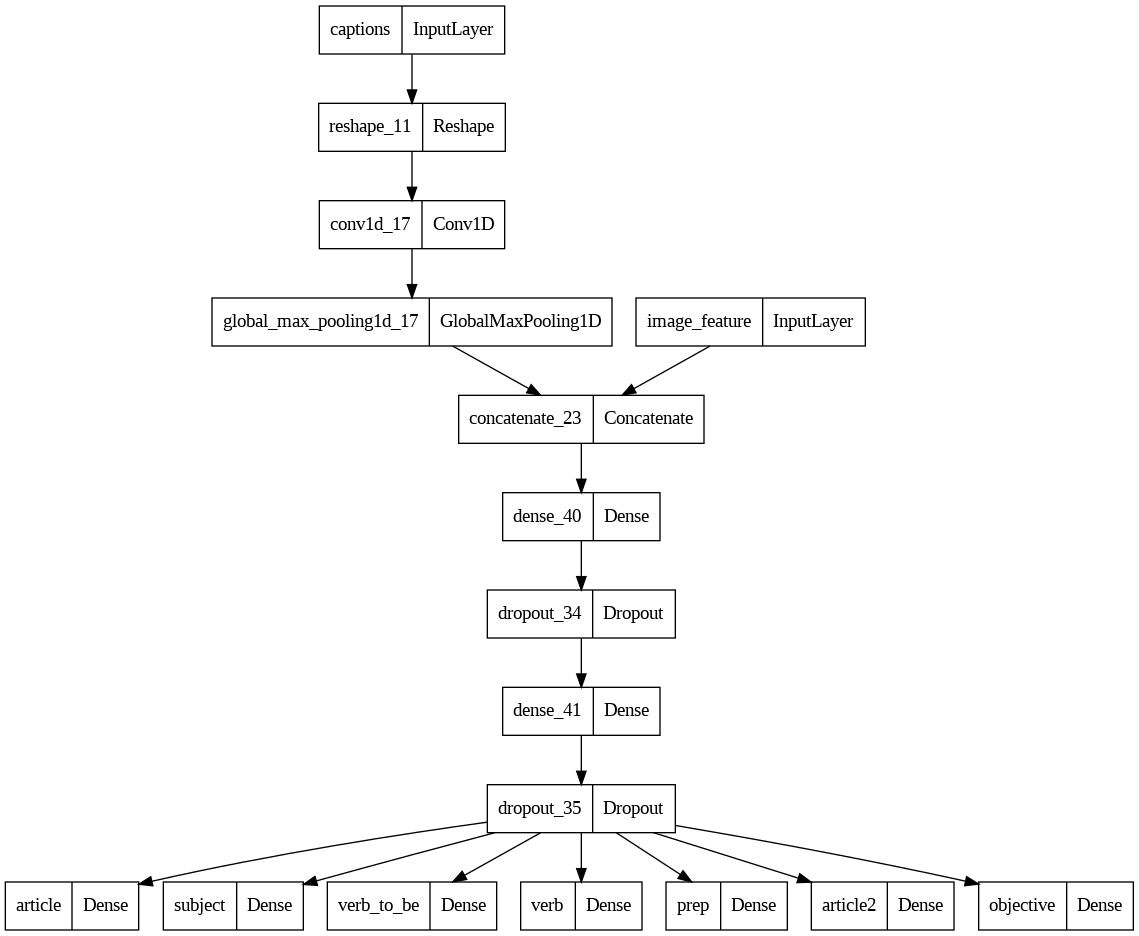

In [198]:
plot_model(caption_model)

# TRAINING ( select 1 option )

In [199]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
history = caption_model.fit(
        input_data, output_data,
        callbacks = [callback],
        batch_size=64,
        epochs=1000)

Epoch 1/1000
3/3 [==============================] - 4s 18ms/step - loss: 19.8117 - article_loss: 2.6078 - subject_loss: 2.7889 - verb_to_be_loss: 2.0373 - verb_loss: 3.7981 - prep_loss: 2.8840 - article2_loss: 1.8163 - objective_loss: 3.8794 - article_accuracy: 0.0296 - subject_accuracy: 0.0148 - verb_to_be_accuracy: 0.3704 - verb_accuracy: 0.0370 - prep_accuracy: 0.0296 - article2_accuracy: 0.4741 - objective_accuracy: 0.0148
Epoch 2/1000
3/3 [==============================] - 0s 16ms/step - loss: 18.2372 - article_loss: 2.2917 - subject_loss: 2.4516 - verb_to_be_loss: 1.8691 - verb_loss: 3.7115 - prep_loss: 2.5561 - article2_loss: 1.5928 - objective_loss: 3.7643 - article_accuracy: 0.0593 - subject_accuracy: 0.0741 - verb_to_be_accuracy: 0.3556 - verb_accuracy: 0.0741 - prep_accuracy: 0.1333 - article2_accuracy: 0.5852 - objective_accuracy: 0.0296
Epoch 3/1000
3/3 [==============================] - 0s 16ms/step - loss: 17.6155 - article_loss: 2.1951 - subject_loss: 2.3381 - verb_to_b

# TEST OUR MODEL

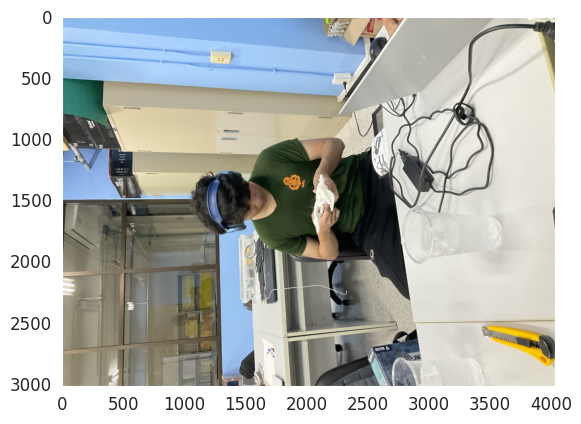

In [200]:
img_size = 224

image = plt.imread("/content/drive/MyDrive/projectMLDL/img/IMG_0230.JPG")
img = load_img(os.path.join("/content/drive/MyDrive/projectMLDL/img/", "IMG_0230.JPG"),target_size=(img_size,img_size))
img = img_to_array(img)
img = img/255.
img = np.expand_dims(img,axis=0)
feature = fe.predict(img, verbose=0)
plt.imshow(image)

In [201]:
import numpy as np

n = 80
#image_features_data = X[n].reshape(1, -1)
image_features_data = feature
data = np.reshape(image_features_data[0], (1, 1920))
captions_data = np.zeros((1, 7))

predictions = caption_model.predict([data, captions_data], verbose=0)

article_prediction = predictions[0]
subject_prediction = predictions[1]
verb_to_be_prediction = predictions[2]
verb_prediction = predictions[3]
preposition_prediction = predictions[4]
second_article_prediction = predictions[5]
objective_prediction = predictions[6]

print(captions[n])
print(reverse_first_article[np.argmax(article_prediction)], end=" ")
print(reverse_subject[np.argmax(subject_prediction)], end=" ")
print(reverse_verb_to_be[np.argmax(verb_to_be_prediction)], end=" ")
print(reverse_verb[np.argmax(verb_prediction)], end=" ")
print(reverse_preposition[np.argmax(preposition_prediction)], end=" ")
print(reverse_second_article[np.argmax(second_article_prediction)], end=" ")
print(reverse_objective[np.argmax(objective_prediction)], end=" ")

KerasTensor(type_spec=TensorSpec(shape=(7,), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")
a man is sitting on the table 

# Model Evaluation with BLEU

In [202]:
def space_to_question_mark(word):
  if word == "":
    return "?"
  return word

In [203]:
predict = []

for i in tqdm(range(int(X.shape[0]))):
  image_features_data = X[i].reshape(1, -1)
  data = np.reshape(image_features_data[0], (1, 1920))
  captions_data = np.zeros((1, 7))

  predictions = caption_model.predict([data, captions_data], verbose=0)

  article_prediction = predictions[0]
  subject_prediction = predictions[1]
  verb_to_be_prediction = predictions[2]
  verb_prediction = predictions[3]
  preposition_prediction = predictions[4]
  second_article_prediction = predictions[5]
  objective_prediction = predictions[6]

  caption_predicted = space_to_question_mark(reverse_first_article[np.argmax(article_prediction)]) + " " + space_to_question_mark(reverse_subject[np.argmax(subject_prediction)]) + " " + space_to_question_mark(reverse_verb_to_be[np.argmax(verb_to_be_prediction)]) + " " + space_to_question_mark(reverse_verb[np.argmax(verb_prediction)]) + " " + space_to_question_mark(reverse_preposition[np.argmax(preposition_prediction)]) + " " + space_to_question_mark(reverse_second_article[np.argmax(second_article_prediction)]) + " " + space_to_question_mark(reverse_objective[np.argmax(objective_prediction)])
  predict.append(caption_predicted)

100%|██████████| 135/135 [00:12<00:00, 10.76it/s]


In [204]:
captions = df['caption']

In [205]:
predict_splited = []
actual_splited = []
for i, p in enumerate(predict):
  predict_splited.append(predict[i].split())
  actual_splited.append([captions[i].split()])

In [206]:
import nltk

nltk.download('punkt')
nltk.download('perluniprops')

from nltk.translate.bleu_score import corpus_bleu

bleu_score = corpus_bleu(actual_splited, predict_splited)

print(f"BLEU Score: {bleu_score}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


BLEU Score: 0.09216164839409055


[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Unzipping misc/perluniprops.zip.
